In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# nX = 1200
# nY = 1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


/code/delon/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/code/delon/LensQuEst/LensQuEst/cmb.py:42: RuntimeWarning: invalid value encountered in scalar multiply
  self.funlensedTT = lambda l: (l>=lmin_unlensedCMB and l<=lmax_unlensedCMB) * self.funlensedTT_template(l) * self.fdl_to_cl(l)


Generate GRF unlensed CMB map (debeamed)
plot unlensed CMB map


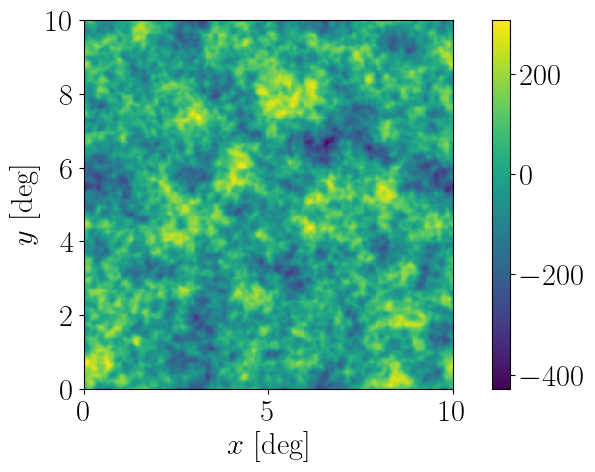

check the power spectrum


/code/delon/LensQuEst/LensQuEst/flat_map.py:462: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


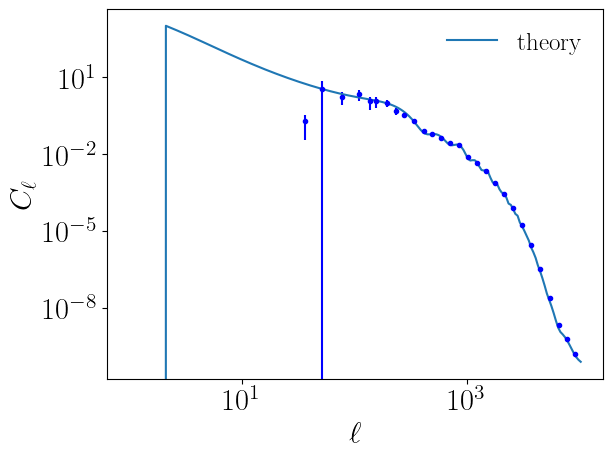

In [8]:
print("Generate GRF unlensed CMB map (debeamed)")

#generate GRF with the same power spectrum as the unlensed CMB
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)
print("plot unlensed CMB map")
baseMap.plot(cmb0)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(cmb0Fourier, theory=[cmb.funlensedTT], plot=True, save=False)

Generate GRF kappa map
plot kappa map


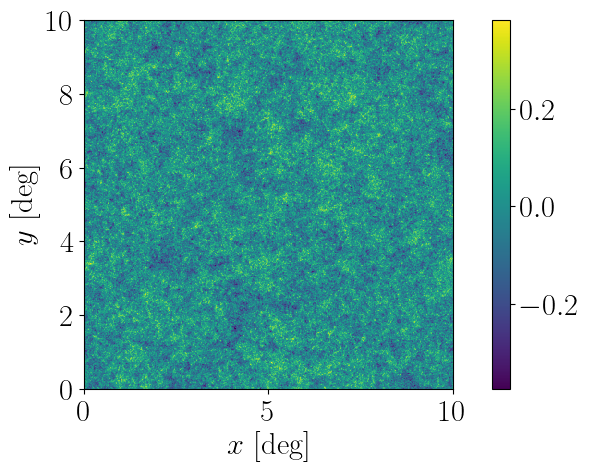

check the power spectrum


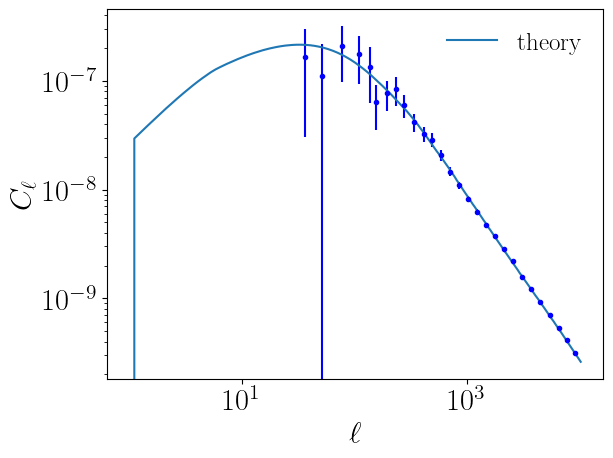

In [9]:
print("Generate GRF kappa map")

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)
print("plot kappa map")
baseMap.plot(kCmb)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(kCmbFourier, theory=[p2d_cmblens.fPinterp], plot=True, save=False)

Lens the CMB map


/code/delon/LensQuEst/LensQuEst/flat_map.py:1208: RuntimeWarning: invalid value encountered in divide
  dxFourier = -2.j * self.lx/self.l**2 * kappaFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1209: RuntimeWarning: invalid value encountered in divide
  dyFourier = -2.j * self.ly/self.l**2 * kappaFourier


plot lensed CMB map


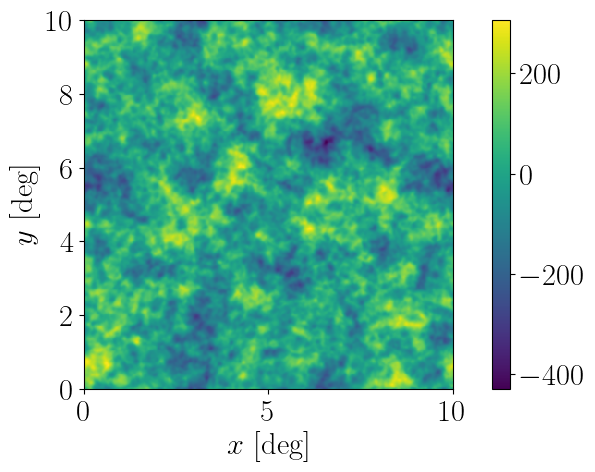

check the power spectrum


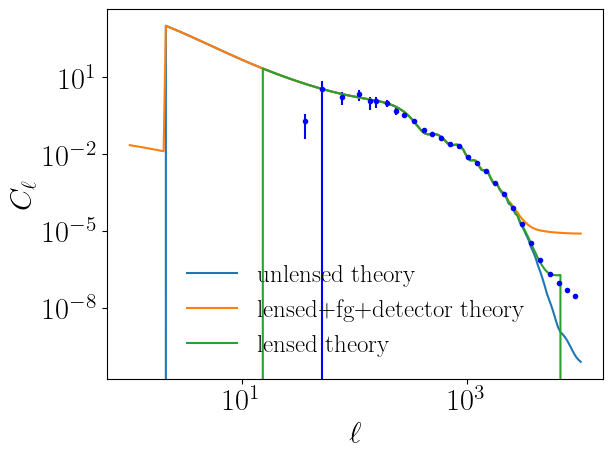

In [10]:
print("Lens the CMB map")

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)
print("plot lensed CMB map")
baseMap.plot(lensedCmb, save=False)
print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(lensedCmbFourier, 
                                      theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+fg+detector', 'lensed'],
                                      plot=True, save=False)

Generate FG map


/code/delon/LensQuEst/LensQuEst/cmb.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/code/delon/LensQuEst/LensQuEst/cmb.py:290: RuntimeWarning: invalid value encountered in scalar multiply
  return a_CIBP * (l/3000.)**2 * self.mu(nu1, betaP, Td)*self.mu(nu2, betaP, Td)/self.mu(150.e9, betaP, Td)**2 * self.fdl_to_cl(l)
/code/delon/LensQuEst/LensQuEst/cmb.py:301: RuntimeWarning: invalid value encountered in scalar multiply
  return a_CIBC * (l/3000.)**(2-n) * self.mu(nu1, betaC, Td)*self.mu(nu2, betaC, Td)/self.mu(150.e9, betaC, Td)**2 * self.fdl_to_cl(l)
/code/delon/LensQuEst/LensQuEst/cmb.py:114: RuntimeWarning: invalid value encountered in scalar multiply
  self.ftSZ = lambda l: (l>=lmin_tSZ and l<=lmax_tSZ) * a_tSZ * self.freqDpdceTSZTemp(self.nu1)*self.freqDpdceTSZTemp(self.nu2)/self.freqDpdceTSZTemp(150.e9)**2 * ftSZ_template(l) * self.fdl_to_cl(l)
/code/delon/LensQuEst/LensQuEst/cmb.py:122: RuntimeWarning: 

plot lensed+FG CMB map


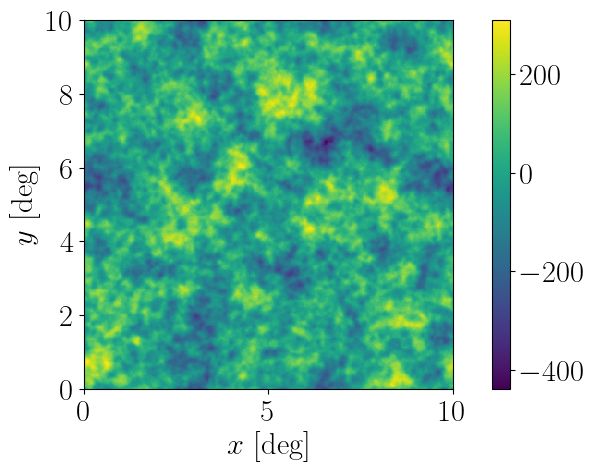

check the power spectrum


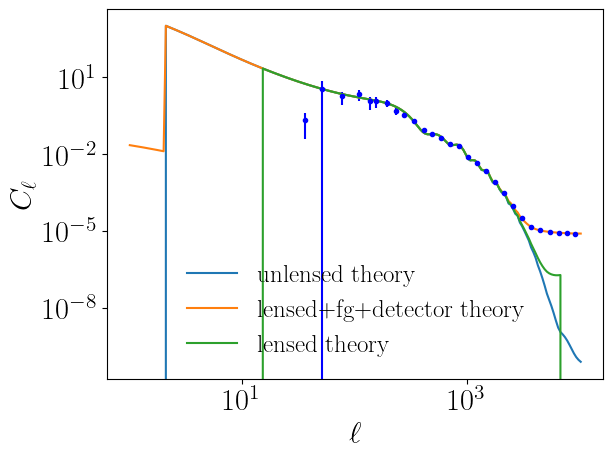

In [11]:

print("Generate FG map")

fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)
print("plot lensed+FG CMB map")
baseMap.plot(lensedCmb, save=False)

print("check the power spectrum")
lCen, Cl, sCl = baseMap.powerSpectrum(lensedCmbFourier, 
                                      theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+fg+detector', 'lensed'],
                                      plot=True, save=False)

Add white detector noise (debeamed)


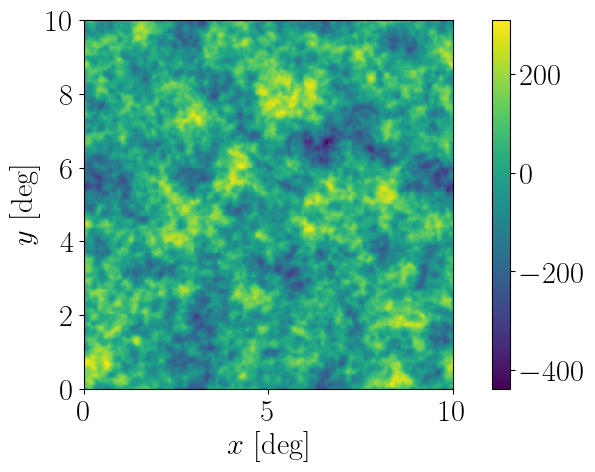

check the power spectrum


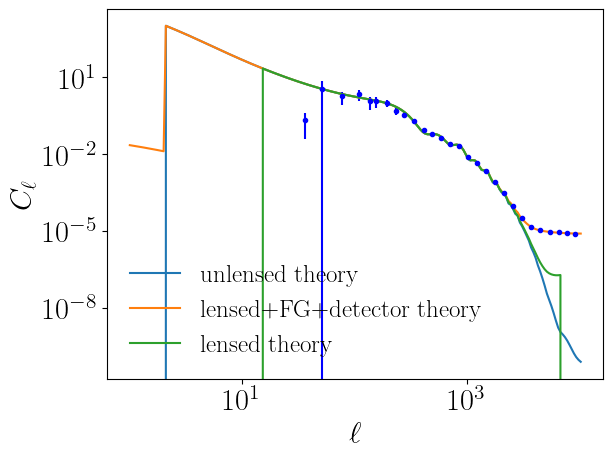

In [12]:
print("Add white detector noise (debeamed)")

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)
baseMap.plot(totalCmb)
print("check the power spectrum")
lCent, Clt, sClt = baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.funlensedTT, cmb.ftotal, cmb.fCtotal], 
                                      theory_l=['unlensed', 'lensed+FG+detector', 'lensed'],
                                          plot=True, save=False)

In [13]:
Nhat_unmasked= baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                       dataFourier=totalCmbFourier, test=False)
_, Nhat_unmasked, _ = baseMap.powerSpectrum(dataFourier=Nhat_unmasked)

/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:2345: RuntimeWarning: invalid value encountered in sqrt
  resultFourier = np.sqrt(np.real(resultFourier))


In [184]:
from scipy.ndimage import gaussian_filter 


def genRandomMask(fsky, nX, nY):
    assert(nX == nY)
    #Ill assume square patches for now
    mask = np.zeros((nX,nY))
    l = int(np.sqrt(fsky)*nX)//2
#     print(l,nX//2-l)
    for iX in range(nX//2-l+1, nX//2+l):
        if(iX<0 or iX > nX-1):
            continue
        for iY in range(nY//2-l+1, nY//2+l):
            if(iY<0 or iY > nY-1):
                continue
#             if(np.random.rand()>0.95):
#                 continue
            mask[iX][iY] = 1
    
    a = np.random.rand()*100+10

    shift = lambda x: nX/(a) * np.sin(2.0*np.pi*x * 2/nY)
    apodized_mask = np.zeros_like(mask)

    for i in range(nX):
        apodized_mask[:,i] = np.roll(mask[:,i], int(shift(i)))
        
    apodized_mask = gaussian_filter(apodized_mask, 2+np.random.rand()*20)
    fsky_true = np.sum(apodized_mask)/(nX*nY)
    return apodized_mask, fsky_true

0.43230625 0.4375


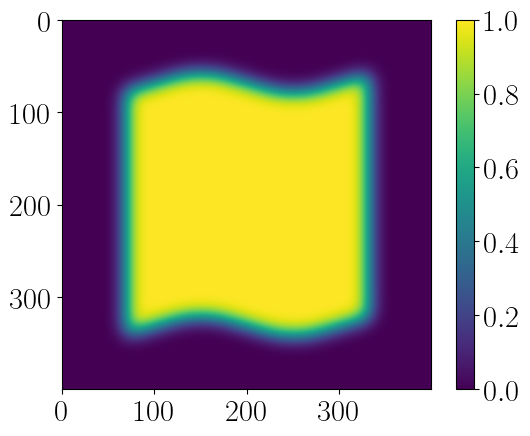

In [278]:
fsky_in =7/16
mask, fsky_true = genRandomMask(fsky_in,nX, nY)
print(fsky_true, fsky_in)
plt.imshow(mask, vmin=0, vmax=1)
plt.colorbar()
plt.savefig('example_mask.pdf', bbox_inches='tight')

In [219]:
fskys_true = []
ratios = []
from tqdm import tqdm, trange
n_runs = 500
for j in trange(n_runs):
    fsky = np.random.rand()
    mask, fsky_true = genRandomMask(fsky,nX, nY)

    totalMaskedCmb = mask*totalCmb
    totalMaskedCmbFourier = baseMap.fourier(totalMaskedCmb)
    Nhat = baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, 
                                                       dataFourier=totalMaskedCmbFourier, test=False)
    _, Nhat, _ = baseMap.powerSpectrum(dataFourier=Nhat)

    Ipos = np.where(Nhat_unmasked >1e-10)
    Ipos2 = np.where(Nhat[Ipos] > 1e-10)
    fskys_true += [fsky_true]
    ratios +=[np.mean(Nhat[Ipos][Ipos2]/Nhat_unmasked[Ipos][Ipos2])]

 70%|███████   | 352/500 [19:20<08:03,  3.27s/it]/home/delon/.conda/envs/nblensing/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/delon/.conda/envs/nblensing/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 500/500 [27:45<00:00,  3.33s/it]


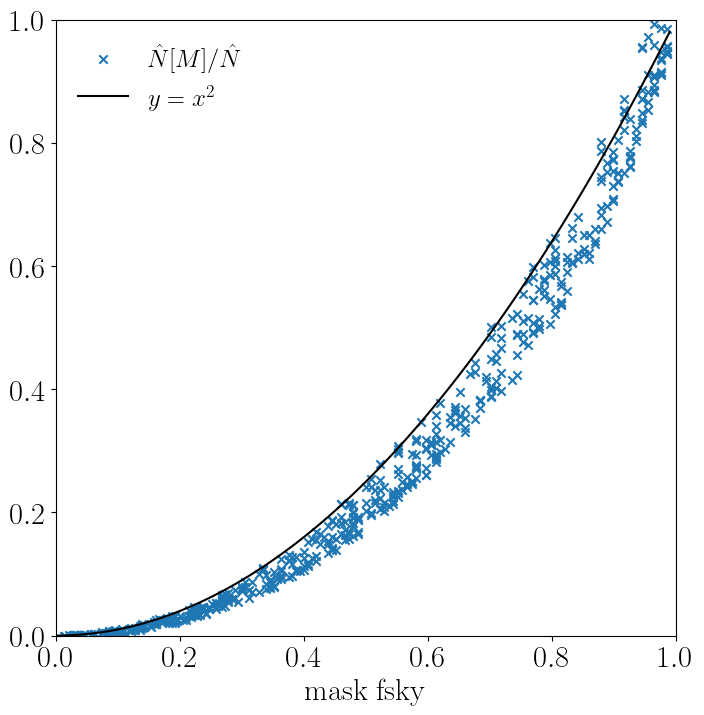

In [279]:
from scipy.stats import binned_statistic

plt.figure(figsize=(8,8))

plt.scatter(fskys_true, ratios, marker='x',label=r'$\hat N [M] / \hat N$')


x = [i/100 for i in range(100)]
y = [(xc)**(2) for xc in x]
plt.plot(x,y, label=r'$y=x^2$', c='black')

plt.legend(frameon=False)
plt.xlabel('mask fsky')
plt.xlim([0,1])
plt.ylim([0,1])

plt.savefig('ratioN_vs_fSkyfromMask.pdf', bbox_inches='tight')

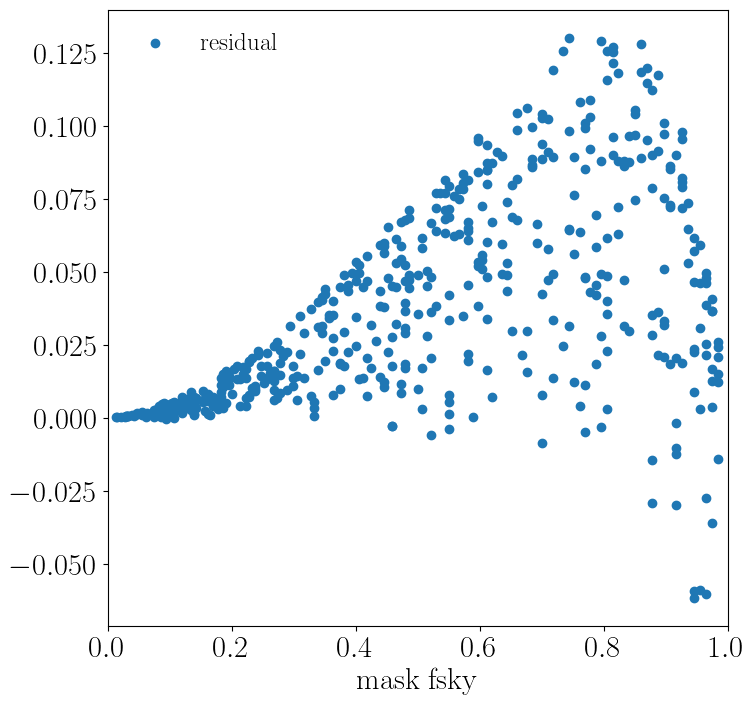

In [257]:
from scipy.stats import binned_statistic

plt.figure(figsize=(8,8))


y = [(fskys_true[idx])**2-ratios[idx] for idx in range(len(fskys_true))]
plt.scatter(fskys_true,y, label=r'residual')

plt.legend(frameon=False)
plt.xlabel('mask fsky')
plt.xlim([0,1])

plt.savefig('ratioN_vs_fSkyfromMask_res.pdf')